<a href="https://colab.research.google.com/github/LithanLoki/220701143-CS19643-FOML-PROJECT/blob/main/FOML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Mount Drive & Import Libraries
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
import joblib


Mounted at /content/drive


In [2]:
# Step 2: Load Data
df = pd.read_csv('/content/drive/MyDrive/injury_data.csv')
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Player_Age            1000 non-null   int64  
 1   Player_Weight         1000 non-null   float64
 2   Player_Height         1000 non-null   float64
 3   Previous_Injuries     1000 non-null   int64  
 4   Training_Intensity    1000 non-null   float64
 5   Recovery_Time         1000 non-null   int64  
 6   Likelihood_of_Injury  1000 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 54.8 KB
None
        Player_Age  Player_Weight  Player_Height  Previous_Injuries  \
count  1000.000000    1000.000000    1000.000000        1000.000000   
mean     28.231000      74.794351     179.750948           0.515000   
std       6.538378       9.892621       9.888921           0.500025   
min      18.000000      40.191912     145.285701           0.000000   
25%      22.000000      6

In [3]:
# Step 3: Feature Engineering
df['BMI'] = df['Player_Weight'] / ((df['Player_Height'] / 100) ** 2)
df['Injury_Per_Year'] = df['Previous_Injuries'] / (df['Player_Age'] - 17 + 1)
df['Intensity_Recovery_Score'] = df['Training_Intensity'] * df['Recovery_Time']


In [4]:
# Step 4: Prepare Data
X = df.drop('Likelihood_of_Injury', axis=1)
y = df['Likelihood_of_Injury']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [5]:
# Step 5: Handle Class Imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)


In [6]:
# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


In [11]:
# Step 7: Train Model with XGBoost
model = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)
model.fit(X_res, y_res)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:31:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

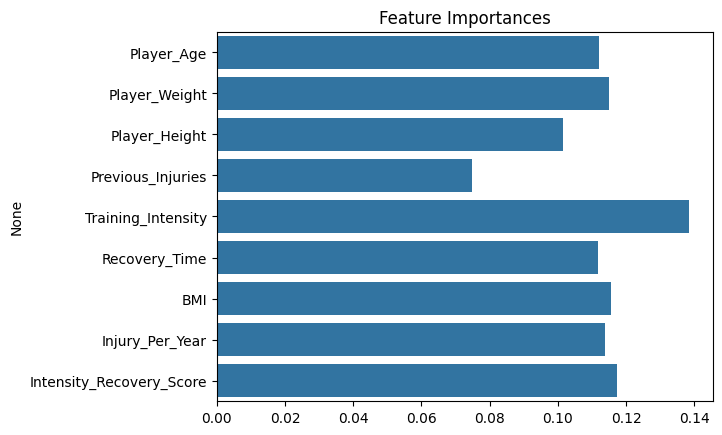

In [13]:
#Feature importances
importances = model.feature_importances_
feat_names = X.columns

sns.barplot(x=importances, y=feat_names)
plt.title("Feature Importances")
plt.show()

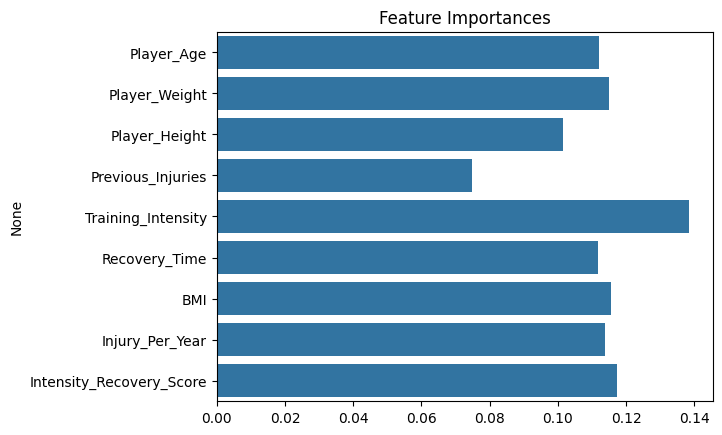

In [14]:
importances = model.feature_importances_
feat_names = X.columns

sns.barplot(x=importances, y=feat_names)
plt.title("Feature Importances")
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        95
           1       0.97      0.97      0.97       105

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200

ROC AUC Score: 0.9966917293233083


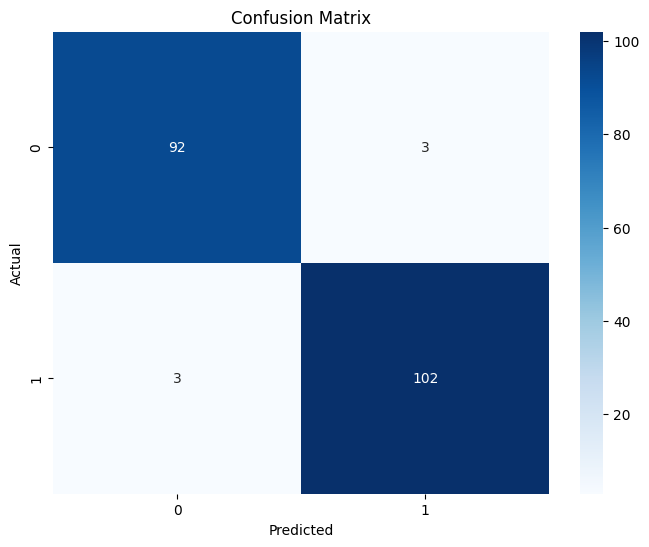

In [28]:
# Step 8: Evaluate Model
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [15]:
# Step 9: Save Model
joblib.dump(model, '/content/drive/MyDrive/injury_model_xgboost.pkl')
print("Model saved successfully.")


Model saved successfully.


In [26]:
def predict_injury_risk(model, scaler, player_data):
    """
    Predict injury risk for a new player.

    Parameters:
        model (object): Trained XGBoost model
        scaler (object): StandardScaler used during training
        player_data (dict): New player data with keys:
            'Player_Age', 'Player_Weight', 'Player_Height',
            'Previous_Injuries', 'Training_Intensity', 'Recovery_Time'

    Returns:
        prediction (int): 0 or 1 (Low/High risk)
        probability (float): Probability of injury
    """
    # Convert to DataFrame
    new_data = pd.DataFrame([player_data])

    # Feature engineering
    new_data['BMI'] = new_data['Player_Weight'] / ((new_data['Player_Height'] / 100) ** 2)
    new_data['Injury_Per_Year'] = new_data['Previous_Injuries'] / (new_data['Player_Age'] - 17 + 1)
    new_data['Intensity_Recovery_Score'] = new_data['Training_Intensity'] * new_data['Recovery_Time']

    # Select and order columns
    cols = ['Player_Age', 'Player_Weight', 'Player_Height', 'Previous_Injuries',
            'Training_Intensity', 'Recovery_Time', 'BMI', 'Injury_Per_Year', 'Intensity_Recovery_Score']

    new_data_scaled = scaler.transform(new_data[cols])

    # Predict
    prediction = model.predict(new_data_scaled)[0]
    probability = model.predict_proba(new_data_scaled)[0][1]

    return prediction, round(probability * 100, 2)


In [27]:
# Example input for a new player
new_player = {
    'Player_Age': 24,
    'Player_Weight': 72.5,
    'Player_Height': 178,
    'Previous_Injuries': 1,
    'Training_Intensity': 0.7,
    'Recovery_Time': 3
}

# Predict
pred, prob = predict_injury_risk(model, scaler, new_player)

print(f"🏏 Injury Risk: {'High' if pred == 1 else 'Low'}")
print(f"📊 Probability of Injury: {prob}%")


🏏 Injury Risk: Low
📊 Probability of Injury: 47.34000015258789%


In [25]:
# New player sample
new_data = pd.DataFrame({
    'Player_Age': [25],
    'Player_Weight': [70.0],
    'Player_Height': [175.0],
    'Previous_Injuries': [1],
    'Training_Intensity': [0.6],
    'Recovery_Time': [4]
})

# Feature engineering
new_data['BMI'] = new_data['Player_Weight'] / ((new_data['Player_Height'] / 100) ** 2)
new_data['Injury_Per_Year'] = new_data['Previous_Injuries'] / (new_data['Player_Age'] - 17 + 1)
new_data['Intensity_Recovery_Score'] = new_data['Training_Intensity'] * new_data['Recovery_Time']

# Align columns
cols = ['Player_Age', 'Player_Weight', 'Player_Height', 'Previous_Injuries',
        'Training_Intensity', 'Recovery_Time', 'BMI', 'Injury_Per_Year', 'Intensity_Recovery_Score']

# Scale using in-memory scaler
new_data_scaled = scaler.transform(new_data[cols])

# Predict
prediction = model.predict(new_data_scaled)
probability = model.predict_proba(new_data_scaled)[0][1]

print("✅ Predicted Injury Risk (0 = Low, 1 = High):", prediction[0])
print("📊 Injury Likelihood Probability:", round(probability * 100, 2), "%")


✅ Predicted Injury Risk (0 = Low, 1 = High): 1
📊 Injury Likelihood Probability: 53.0 %
